In [1]:
import re
import unicodedata
import html
import emoji
import pandas as pd
from pathlib import Path
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
# Download NLTK assets if not present
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

# Load spaCy English model (lightweight)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

STOPWORDS = set(stopwords.words("english"))
LEM = WordNetLemmatizer()

SLANG_MAP = {
    "im": "i am", "ive": "i have", "idk": "i do not know", "lol": "laugh out loud",
    "lmao": "laughing my ass off", "wtf": "what the fuck", "omg": "oh my god",
    "btw": "by the way", "tbh": "to be honest", "u": "you", "ur": "your",
    "dont": "do not", "cant": "can not", "wont": "will not", "gonna": "going to",
    "wanna": "want to", "gotta": "got to", "aint": "is not", "idc": "i do not care"
}


def normalize_unicode(text: str) -> str:
    """Ensure consistent unicode representation and decode HTML entities."""
    text = unicodedata.normalize("NFC", str(text))
    text = html.unescape(text)
    return text


def clean_text(text: str) -> str:
    """Normalize, expand slang, demojize, tokenize, remove stopwords, lemmatize."""
    if not isinstance(text, str):
        return ""

    # Unicode + HTML normalization
    t = normalize_unicode(text)

    # Remove HTML tags like <br />, etc.
    t = re.sub(r"<[^>]+>", " ", t)

    # Replace emojis with text names
    t = emoji.demojize(t, delimiters=(" ", " "))

    # Remove control / invisible chars
    t = re.sub(r"[\u0000-\u001f\u007f-\u009f]", " ", t)

    # Normalize spaces and punctuation
    t = re.sub(r"[^\w\s!?',.:;()\-]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()

    # Expand slang
    for k, v in SLANG_MAP.items():
        t = re.sub(rf"\b{k}\b", v, t)

    # Tokenize + Lemmatize + Stopword Removal
    doc = nlp(t)
    tokens = []
    for tok in doc:
        lemma = LEM.lemmatize(tok.lemma_)
        if lemma not in STOPWORDS and lemma.strip():
            tokens.append(lemma)

    return " ".join(tokens)


def run(inp="data/IMDB_Dataset.csv", out="data/IMDB_clean.csv"):
    print(f"Reading {inp} ...")
    df = pd.read_csv(inp)

    if "review" not in df.columns:
        raise KeyError("Expected a 'review' column in the input CSV.")

    # Apply cleaning
    print("Cleaning and preprocessing reviews...")
    df["text"] = df["review"].astype(str).map(clean_text)

    # Map sentiment labels
    if "sentiment" in df.columns:
        df["label"] = (df["sentiment"].astype(str).str.lower() == "positive").astype(int)

    # Drop empties / duplicates
    df = df[df["text"].str.strip() != ""]
    df = df.drop_duplicates(subset=["text"])

    Path(out).parent.mkdir(parents=True, exist_ok=True)
    df[["text", "label"]].to_csv(out, index=False)
    print(f"Saved cleaned dataset -> {out} ({len(df)} rows)")

    # Display one example
    print("\nSample cleaned review:\n", df.text.iloc[0][:300], "...")


if __name__ == "__main__":
    run()

Reading data/IMDB_Dataset.csv ...
Cleaning and preprocessing reviews...
Saved cleaned dataset -> data/IMDB_clean.csv (49574 rows)

Sample cleaned review:
 one reviewer mention watch 1 oz episode hook . right , exactly happen I . first thing strike I oz brutality unflinche scene violence , set right word go . trust I , show faint hearted timid . show pull punch regard drug , sex violence . hardcore , classic use word . call oz nickname give oswald maxi ...


In [3]:
# src/training.py
import os
from pathlib import Path
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

In [4]:
def build_models():
    """Classic baselines: BoW/TF-IDF × {LogReg, ComplementNB}."""
    return {
        # Bag of Words
        "bow_lr": Pipeline([
            ("vect", CountVectorizer(max_features=50_000, ngram_range=(1, 2))),
            ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
        ]),
        "bow_nb": Pipeline([
            ("vect", CountVectorizer(max_features=50_000, ngram_range=(1, 2))),
            ("clf", ComplementNB())
        ]),
        # TF-IDF
        "tfidf_lr": Pipeline([
            ("vect", TfidfVectorizer(max_features=50_000, ngram_range=(1, 2))),
            ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
        ]),
        "tfidf_nb": Pipeline([
            ("vect", TfidfVectorizer(max_features=50_000, ngram_range=(1, 2))),
            ("clf", ComplementNB())
        ]),
    }

def train_eval(name, model, X_tr, y_tr, X_va, y_va, X_te, y_te, out_dir):
    """Fit on TRAIN, report on VAL and TEST, then save."""
    print(f"\n========== {name} ==========")
    model.fit(X_tr, y_tr)

    print("\nValidation results:")
    va_pred = model.predict(X_va)
    print(classification_report(y_va, va_pred, digits=4))

    print("\nTest results:")
    te_pred = model.predict(X_te)
    print(classification_report(y_te, te_pred, digits=4))

    acc = accuracy_score(y_te, te_pred)
    f1  = f1_score(y_te, te_pred, average="macro")

    Path(out_dir).mkdir(parents=True, exist_ok=True)
    path = os.path.join(out_dir, f"{name}.joblib")
    joblib.dump(model, path)
    print(f"Saved -> {path}")

    return {"model": name, "test_acc": acc, "test_f1": f1}

def main():
    data_path = "data/IMDB_clean.csv"
    out_dir = "models"

    df = pd.read_csv(data_path)
    if not {"text", "label"}.issubset(df.columns):
        raise KeyError(f"{data_path} must have columns: text,label")
    X, y = df["text"], df["label"].astype(int)

    # Train / Test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )
    # Train / Val split
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_tr, y_tr, test_size=0.10, stratify=y_tr, random_state=42
    )

    models = build_models()
    results = []
    for name, model in models.items():
        res = train_eval(name, model, X_tr, y_tr, X_va, y_va, X_te, y_te, out_dir)
        results.append(res)

    print("\n=== Summary (Test) ===")
    for r in results:
        print(f"{r['model']:10s}  ACC={r['test_acc']:.4f}  F1={r['test_f1']:.4f}")

if __name__ == "__main__":
    main()



========== bow_lr ==========

Validation results:
              precision    recall  f1-score   support

           0     0.8969    0.8846    0.8907      1976
           1     0.8870    0.8990    0.8929      1990

    accuracy                         0.8918      3966
   macro avg     0.8919    0.8918    0.8918      3966
weighted avg     0.8919    0.8918    0.8918      3966


Test results:
              precision    recall  f1-score   support

           0     0.8923    0.8872    0.8897      4939
           1     0.8887    0.8937    0.8912      4976

    accuracy                         0.8905      9915
   macro avg     0.8905    0.8905    0.8905      9915
weighted avg     0.8905    0.8905    0.8905      9915

Saved -> models\bow_lr.joblib

========== bow_nb ==========

Validation results:
              precision    recall  f1-score   support

           0     0.8730    0.8801    0.8765      1976
           1     0.8799    0.8729    0.8764      1990

    accuracy                       

In [6]:
# Ensemble methods

import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Paths / options
DATA_PATH = Path("data/IMDB_clean.csv")
OUT_DIR   = Path("models_ensemble")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def plot_confusion(y_true, y_pred, title, out_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"]
    )
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    if out_path is not None:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path)
    plt.show()
    plt.close()

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n{'='*10} Training {name} {'='*10}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")

    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {acc:.4f}  |  Macro-F1: {f1:.4f}")

    plot_confusion(
        y_test, y_pred, f"{name} — Confusion Matrix",
        OUT_DIR / f"{name}_cm.png"   # pass None here if you don't want a file saved
    )

    joblib.dump(model, OUT_DIR / f"{name}.joblib")
    print(f"Saved model -> {OUT_DIR / f'{name}.joblib'}")

    return {"model": name, "acc": acc, "f1": f1}


In [13]:
def build_models():
    tfidf = TfidfVectorizer(max_features=50_000, ngram_range=(1,2))

    # Bagging — Random Forest
    bagging = Pipeline([
        ("tfidf", tfidf),
        ("clf", RandomForestClassifier(
            n_estimators=200, max_depth=None, n_jobs=-1, random_state=42))
    ])

    # Boosting — AdaBoost & XGBoost
    ada = Pipeline([
        ("tfidf", tfidf),
        ("clf", AdaBoostClassifier(n_estimators=200, random_state=42))
    ])
    
    xgb_clf = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50_000, ngram_range=(1, 2))),
        ("clf", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",  
            n_jobs=-1,
            random_state=42
        ))
    ])

    # Voting — hard & soft
    lr  = LogisticRegression(max_iter=2000)
    nb  = ComplementNB()
    svm = LinearSVC()

    voting_hard = Pipeline([
        ("tfidf", tfidf),
        ("clf", VotingClassifier(
            estimators=[("lr", lr), ("nb", nb), ("svm", svm)],
            voting="hard"))
    ])
    voting_soft = Pipeline([
        ("tfidf", tfidf),
        ("clf", VotingClassifier(
            estimators=[("lr", lr), ("nb", nb)],
            voting="soft"))
    ])

    # Stacking — meta-learner Logistic Regression
    base_learners = [("lr", lr), ("nb", nb), ("svm", svm)]
    stacking = Pipeline([
        ("tfidf", tfidf),
        ("clf", StackingClassifier(
            estimators=base_learners,
            final_estimator=LogisticRegression(max_iter=2000),
            n_jobs=-1))
    ])

    return {
        "bagging_rf":  bagging,
        "boosting_ada": ada,
        "boosting_xgb": xgb_clf,
        "voting_hard": voting_hard,
        "voting_soft": voting_soft,
        "stacking":    stacking
    }



========== Training bagging_rf ==========
              precision    recall  f1-score   support

           0     0.8646    0.8625    0.8636      4939
           1     0.8639    0.8660    0.8649      4976

    accuracy                         0.8642      9915
   macro avg     0.8642    0.8642    0.8642      9915
weighted avg     0.8642    0.8642    0.8642      9915

Accuracy: 0.8642  |  Macro-F1: 0.8642


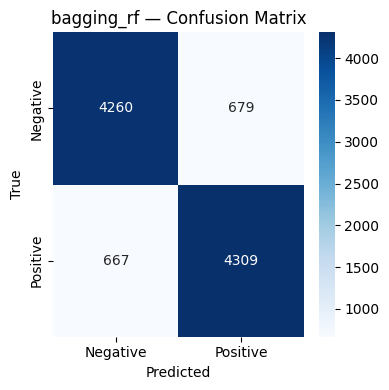

Saved model -> models_ensemble\bagging_rf.joblib

========== Training boosting_ada ==========
              precision    recall  f1-score   support

           0     0.8400    0.7560    0.7958      4939
           1     0.7797    0.8571    0.8166      4976

    accuracy                         0.8068      9915
   macro avg     0.8099    0.8066    0.8062      9915
weighted avg     0.8098    0.8068    0.8062      9915

Accuracy: 0.8068  |  Macro-F1: 0.8062


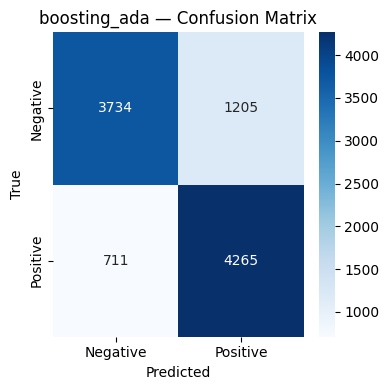

Saved model -> models_ensemble\boosting_ada.joblib

========== Training boosting_xgb ==========
              precision    recall  f1-score   support

           0     0.8847    0.8439    0.8638      4939
           1     0.8518    0.8909    0.8709      4976

    accuracy                         0.8675      9915
   macro avg     0.8683    0.8674    0.8674      9915
weighted avg     0.8682    0.8675    0.8674      9915

Accuracy: 0.8675  |  Macro-F1: 0.8674


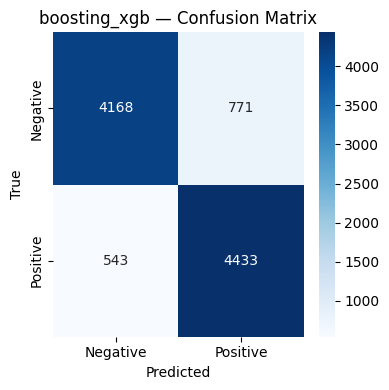

Saved model -> models_ensemble\boosting_xgb.joblib

========== Training voting_hard ==========
              precision    recall  f1-score   support

           0     0.9076    0.8925    0.9000      4939
           1     0.8950    0.9098    0.9023      4976

    accuracy                         0.9012      9915
   macro avg     0.9013    0.9011    0.9011      9915
weighted avg     0.9013    0.9012    0.9012      9915

Accuracy: 0.9012  |  Macro-F1: 0.9011


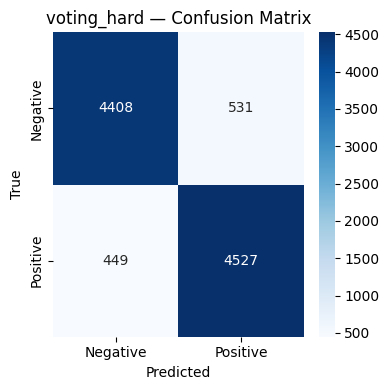

Saved model -> models_ensemble\voting_hard.joblib

========== Training voting_soft ==========
              precision    recall  f1-score   support

           0     0.9043    0.8882    0.8962      4939
           1     0.8910    0.9068    0.8988      4976

    accuracy                         0.8975      9915
   macro avg     0.8977    0.8975    0.8975      9915
weighted avg     0.8976    0.8975    0.8975      9915

Accuracy: 0.8975  |  Macro-F1: 0.8975


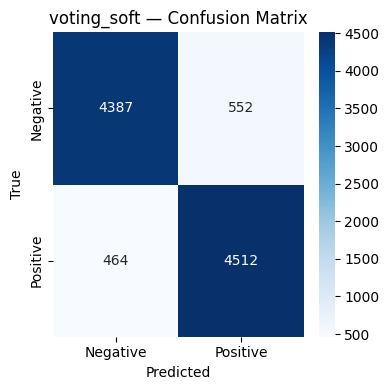

Saved model -> models_ensemble\voting_soft.joblib

========== Training stacking ==========
              precision    recall  f1-score   support

           0     0.9070    0.9006    0.9038      4939
           1     0.9020    0.9084    0.9052      4976

    accuracy                         0.9045      9915
   macro avg     0.9045    0.9045    0.9045      9915
weighted avg     0.9045    0.9045    0.9045      9915

Accuracy: 0.9045  |  Macro-F1: 0.9045


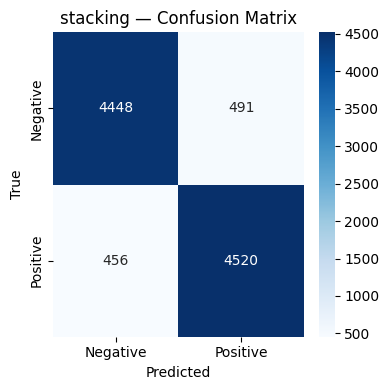

Saved model -> models_ensemble\stacking.joblib


,model,acc,f1
0,stacking,0.904488,0.904483
1,voting_hard,0.901160,0.901146
2,voting_soft,0.897529,0.897513
3,boosting_xgb,0.867474,0.867379
4,bagging_rf,0.864246,0.864243
5,boosting_ada,0.806757,0.806202


In [15]:
# Load dataset
df = pd.read_csv(DATA_PATH)
assert {"text","label"}.issubset(df.columns), "CSV must contain text,label columns."

X = df["text"]; y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train & evaluate ensembles
models = build_models()
results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)

# Summary table
summary = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
summary



========== Training stacking_improved ==========
              precision    recall  f1-score   support

           0     0.9098    0.9024    0.9061      4939
           1     0.9039    0.9112    0.9075      4976

    accuracy                         0.9068      9915
   macro avg     0.9068    0.9068    0.9068      9915
weighted avg     0.9068    0.9068    0.9068      9915

Accuracy: 0.9068  |  Macro-F1: 0.9068


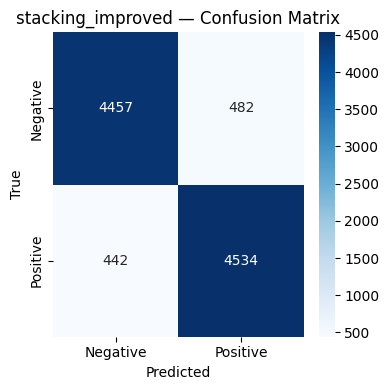

Saved model -> models_ensemble\stacking_improved.joblib


,model,acc,f1
0,stacking_improved,0.906808,0.906802
1,stacking,0.904488,0.904483
2,voting_hard,0.901160,0.901146
3,voting_soft,0.897529,0.897513
4,boosting_xgb,0.867474,0.867379
5,bagging_rf,0.864246,0.864243
6,boosting_ada,0.806757,0.806202


In [17]:
# ===== Improved Stacking =====
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier

# 1) Feature extractors
word_tfidf = TfidfVectorizer(
    max_features=100_000, ngram_range=(1, 2), min_df=2, sublinear_tf=True
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3, 5), min_df=2, lowercase=False,
    max_features=100_000
)

# 2) Diverse base learners
base_lr = Pipeline([
    ("tfidf", word_tfidf),
    ("clf", LogisticRegression(C=4.0, solver="liblinear", max_iter=4000))
])

base_nb = Pipeline([
    ("tfidf", word_tfidf),
    ("clf", ComplementNB(alpha=0.5))
])

# Calibrated SVM (NOTE: use 'estimator=', not 'base_estimator=')
base_svm = Pipeline([
    ("tfidf", char_tfidf),
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(C=1.0),   # <- fixed
        method="sigmoid", cv=3
    ))
])

estimators = [
    ("lr_word", base_lr),
    ("nb_word", base_nb),
    ("svm_char", base_svm),
]

# 3) Meta-learner (CV on probs from bases)
meta = LogisticRegressionCV(Cs=10, cv=5, solver="liblinear", max_iter=4000)

stacking_improved = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method="predict_proba",   # use calibrated probabilities
    cv=5,                           # out-of-fold predictions
    n_jobs=-1
)

# 4) Train & evaluate with your existing helper
res_stack = evaluate_model(
    "stacking_improved", stacking_improved,
    X_train, y_train.astype(int), X_test, y_test.astype(int)
)

# 5) Update summary (if present)
try:
    summary = (
        pd.concat([summary, pd.DataFrame([res_stack])], ignore_index=True)
          .sort_values("f1", ascending=False)
          .reset_index(drop=True)
    )
    display(summary)
except NameError:
    display(pd.DataFrame([res_stack]))


In [21]:
# Deep learning: LSTM baseline

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("data/IMDB_clean.csv")
texts  = df["text"].astype(str).tolist()
labels = df["label"].astype(int).values            # <-- make labels a NumPy array

# Tokenize & pad
max_words = 20000
max_len   = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
seqs = tokenizer.texts_to_sequences(texts)
X    = pad_sequences(seqs, maxlen=max_len)
y    = labels.astype("int32")

# Train / test / val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# use an explicit validation set instead of validation_split (avoids the issue entirely)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# Callbacks
early = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
rlr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)

# Train (now using validation_data rather than validation_split)
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=8,
    validation_data=(X_val, y_val),
    callbacks=[early, rlr],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test accuracy: {acc:.4f}")


c:\Users\brand\Downloads\NLP_Project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
558/558 ━━━━━━━━━━━━━━━━━━━━ 116s 203ms/step - accuracy: 0.8578 - loss: 0.3300 - val_accuracy: 0.8913 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 2/8
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9373 - loss: 0.1735
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
558/558 ━━━━━━━━━━━━━━━━━━━━ 134s 240ms/step - accuracy: 0.9351 - loss: 0.1769 - val_accuracy: 0.8886 - val_loss: 0.2855 - learning_rate: 0.0010
Epoch 3/8
558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9715 - loss: 0.0846
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
558/558 ━━━━━━━━━━━━━━━━━━━━ 144s 258ms/step - accuracy: 0.9707 - loss: 0.0855 - val_accuracy: 0.8792 - val_loss: 0.3963 - learning_rate: 5.0000e-04
LSTM Test accuracy: 0.8918


In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# Build CNN model
cnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.summary()

# Train
cnn_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

# Evaluate
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test accuracy: {accuracy:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8142 - loss: 0.4063 - val_accuracy: 0.8675 - val_loss: 0.3136
Epoch 2/5
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9107 - loss: 0.2272 - val_accuracy: 0.8776 - val_loss: 0.2984
Epoch 3/5
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9641 - loss: 0.1062 - val_accuracy: 0.8669 - val_loss: 0.3496
Epoch 4/5
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9882 - loss: 0.0410 - val_accuracy: 0.8647 - val_loss: 0.4309
Epoch 5/5
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9958 - loss: 0.0166 - val_accuracy: 0.8599 - val_loss: 0.5181
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8681 - loss: 0.4879
CNN Test accuracy: 0.8681


In [33]:
#Fine-tuning BERT/DistilBERT with Transformers

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)
from torch.utils.data import Dataset
import numpy as np
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

class IMDBDataset(Dataset):
    """Custom Dataset for IMDB reviews."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

def compute_metrics(eval_pred):
    """Compute accuracy and F1 score."""
    try:
        preds, labels = eval_pred
    except Exception:
        preds, labels = eval_pred.predictions, eval_pred.label_ids
    
    preds = np.argmax(preds, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='binary')
    }

def main():
    # Set seed for reproducibility
    set_seed(42)
    
    # Detect device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    df = pd.read_csv("data/IMDB_clean.csv")
    texts = df["text"].astype(str).tolist()
    labels = df["label"].astype(int).tolist()
    
    print(f"Total samples: {len(texts)}")
    print(f"Label distribution: {pd.Series(labels).value_counts().to_dict()}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Tokenize
    print("Tokenizing...")
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    
    train_enc = tokenizer(X_train, truncation=True, padding=True, max_length=200)
    test_enc = tokenizer(X_test, truncation=True, padding=True, max_length=200)
    
    train_ds = IMDBDataset(train_enc, y_train)
    test_ds = IMDBDataset(test_enc, y_test)
    
    # Load model
    print("Loading model...")
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", 
        num_labels=2
    ).to(device)
    
    # Training arguments with best practices
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=5e-5,
        weight_decay=0.01,  # L2 regularization
        warmup_steps=500,  # Learning rate warmup
        logging_dir="./logs",
        logging_steps=100,
        eval_strategy="epoch",  # Evaluate after each epoch
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        save_total_limit=2,  # Keep only 2 best checkpoints
        report_to="none",  # Disable wandb/tensorboard logging
        fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    )
    
    # Create trainer - use processing_class instead of tokenizer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        processing_class=tokenizer,  # Updated parameter name
        compute_metrics=compute_metrics,
    )
    
    # Train
    print("\nStarting training...")
    trainer.train()
    
    # Evaluate
    print("\nEvaluating on test set...")
    results = trainer.evaluate()
    
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    print(f"Test Accuracy: {results.get('eval_accuracy', float('nan')):.4f}")
    print(f"Test F1 Score: {results.get('eval_f1', float('nan')):.4f}")
    print(f"Test Loss:     {results.get('eval_loss', float('nan')):.4f}")
    print("="*50)
    
    # Save the model
    print("\nSaving model...")
    model.save_pretrained("./final_model")
    tokenizer.save_pretrained("./final_model")
    print("Model saved to ./final_model")
    
    return results

if __name__ == "__main__":
    results = main()



Using device: cpu
Loading data...
Total samples: 49574
Label distribution: {1: 24879, 0: 24695}
Train samples: 39659, Test samples: 9915
Tokenizing...
Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.281400,0.243393,0.903782,0.903947
2,0.184700,0.278117,0.913162,0.913354
3,0.073300,0.391894,0.911246,0.912141



Evaluating on test set...



FINAL RESULTS
Test Accuracy: 0.9132
Test F1 Score: 0.9134
Test Loss:     0.2781

Saving model...
Model saved to ./final_model


In [1]:
# Using Pre-trained GloVe Embeddings

import os, zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# ---------------- Helpers ----------------
def ensure_glove_local(glove_dir="data", dim=100):
    """
    Use a local GloVe 6B download placed under `glove_dir`.
    If glove.6B.zip exists but the target .txt doesn't, extract only the needed file.
    Returns the full path to glove.6B.{dim}d.txt.
    """
    assert dim in (50, 100, 200, 300)
    os.makedirs(glove_dir, exist_ok=True)
    txt_name = f"glove.6B.{dim}d.txt"
    zip_name = "glove.6B.zip"
    txt_path = os.path.join(glove_dir, txt_name)
    zip_path = os.path.join(glove_dir, zip_name)

    # If the .txt is already there, just use it
    if os.path.exists(txt_path):
        return txt_path

    # Otherwise, if the zip is there, extract the one file we need
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, "r") as zf:
            # guard: make sure the file exists inside the zip
            members = {zi.filename for zi in zf.infolist()}
            if txt_name not in members:
                raise FileNotFoundError(
                    f"{txt_name} not found inside {zip_name}. "
                    "Ensure you downloaded the official glove.6B.zip."
                )
            zf.extract(txt_name, glove_dir)
        if os.path.exists(txt_path):
            return txt_path

    # If we get here, we couldn't find either the .txt or a usable zip
    raise FileNotFoundError(
        f"Couldn't find {txt_name} in '{glove_dir}', and {zip_name} wasn't found or didn't contain it.\n"
        f"Place glove.6B.zip (or the extracted {txt_name}) into the '{glove_dir}' folder."
    )

def load_glove_as_dict(glove_txt_path):
    embeddings_index = {}
    with open(glove_txt_path, encoding="utf-8") as f:
        for line in f:
            values = line.rstrip().split(" ")
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index

# ---------------- Config ----------------
DATA_CSV   = "data/IMDB_clean.csv"   # your dataset
MAX_WORDS  = 10000                   # vocab cap (incl. OOV)
MAX_LEN    = 200                     # sequence length
EMB_DIM    = 100                     # GloVe dimension (50/100/200/300)
TEST_SIZE  = 0.20
VAL_SPLIT  = 0.10
EPOCHS     = 5
BATCH_SIZE = 32
OOV_TOKEN  = "<OOV>"

# ---------------- Data ----------------
df = pd.read_csv(DATA_CSV)
texts  = df["text"].astype(str).tolist()
labels = df["label"].astype(int).to_numpy()

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding="pre", truncating="pre", value=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=TEST_SIZE, stratify=labels, random_state=42
)

# ---------------- GloVe (LOCAL) ----------------
glove_path = ensure_glove_local(glove_dir="data", dim=EMB_DIM)
embeddings_index = load_glove_as_dict(glove_path)
print(f"Loaded {len(embeddings_index):,} GloVe vectors from {glove_path}")

# ---------------- Embedding matrix ----------------
word_index = tokenizer.word_index              # token -> id (1..)
vocab_size = min(MAX_WORDS, len(word_index) + 1)  # +1 for PAD at index 0
embedding_matrix = np.zeros((vocab_size, EMB_DIM), dtype="float32")

for word, idx in word_index.items():
    if idx >= vocab_size:
        continue
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=EMB_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False,   # freeze pretrained embeddings
    mask_zero=True     # ignore padding token id 0
)

# ---------------- Model ----------------
model = Sequential([
    embedding_layer,
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VAL_SPLIT,
    callbacks=callbacks,
    verbose=1
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPretrained Embedding LSTM — Test accuracy: {acc:.4f}")


Loaded 400,000 GloVe vectors from data\glove.6B.100d.txt


c:\Users\brand\Downloads\NLP_Project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 72s 61ms/step - accuracy: 0.7878 - loss: 0.4538 - val_accuracy: 0.8323 - val_loss: 0.3771
Epoch 2/5
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - accuracy: 0.8436 - loss: 0.3632 - val_accuracy: 0.8553 - val_loss: 0.3358
Epoch 3/5
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.8661 - loss: 0.3160 - val_accuracy: 0.8712 - val_loss: 0.3057
Epoch 4/5
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.8787 - loss: 0.2911 - val_accuracy: 0.8689 - val_loss: 0.2940
Epoch 5/5
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.8895 - loss: 0.2691 - val_accuracy: 0.8792 - val_loss: 0.2798

Pretrained Embedding LSTM — Test accuracy: 0.8784


In [6]:
# ===== Config (edit paths as needed) =====

PCA_DIM       = 100                       # target dim before clustering (speed/denoise)
GLOVE_TXT     = "data/glove.6B.100d.txt"  # set to None to skip GloVe
GLOVE_DIM     = 100
FINETUNED_DIR = "final_model"             # folder with config.json, model.safetensors, vocab.txt
K_RANGE       = (2, 6)                    # desired K range; will be clipped to data size
DBSCAN_EPS    = 0.35
DBSCAN_MINPTS = 5


In [7]:
import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[@#]\w+", " ", s)
    s = re.sub(r"[^a-z0-9'\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [9]:
# Embedding builders

def tfidf_embeddings(texts_clean):
    # Adaptive min_df for tiny samples
    min_df = 1 if len(texts_clean) < 20 else 2
    vec = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=min_df)
    X = vec.fit_transform(texts_clean)
    return X

def load_glove(path):
    if (path is None) or (not os.path.exists(path)):
        raise FileNotFoundError("GloVe file not found at: {}".format(path))
    idx = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            p = line.rstrip().split(" ")
            idx[p[0]] = np.asarray(p[1:], dtype="float32")
    return idx

def avg_glove(texts_clean, glove, dim):
    out = np.zeros((len(texts_clean), dim), dtype="float32")
    for i, doc in enumerate(texts_clean):
        toks = doc.split()
        vecs = [glove[w] for w in toks if w in glove]
        if vecs:
            v = np.mean(vecs, axis=0)
            out[i] = v / (np.linalg.norm(v) + 1e-9)
    return out

def sbert_embeddings(texts_raw):
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    X = model.encode(texts_raw, batch_size=64, convert_to_numpy=True, show_progress_bar=False)
    return normalize(X)


In [11]:
# build embeddings for a list of texts

def build_embeddings(texts, use_tfidf=True, use_glove=True, use_sbert=True):
    # normalize input
    texts = pd.Series(texts).astype(str).str.strip()
    texts = texts[texts.str.len() > 0].tolist()
    texts_clean = [clean_text(t) for t in texts]

    embs = {}

    if use_tfidf:
        try:
            X = tfidf_embeddings(texts_clean)
            embs["tfidf"] = X
        except Exception as e:
            print("TF-IDF skipped:", e)

    if use_glove and (GLOVE_TXT is not None):
        try:
            glove = load_glove(GLOVE_TXT)
            X = avg_glove(texts_clean, glove, GLOVE_DIM)
            embs["glove"] = X
        except Exception as e:
            print("GloVe skipped:", e)

    if use_sbert:
        try:
            X = sbert_embeddings(texts)
            embs["sbert"] = X
        except Exception as e:
            print("Sentence-BERT skipped (pip install sentence-transformers):", e)

    return texts, texts_clean, embs


In [33]:
def prepare_for_clustering(X):
    Xd = X.toarray() if hasattr(X, "toarray") else X
    n_samples, n_features = Xd.shape
    
    # PCA can't exceed min(n_samples, n_features) - 1
    max_components = min(n_samples - 1, n_features)
    
    if Xd.shape[1] > PCA_DIM and max_components >= PCA_DIM:
        # Use PCA_DIM if we have enough samples and features
        n_comp = PCA_DIM
        Xp = PCA(n_components=n_comp, random_state=42).fit_transform(Xd)
    elif Xd.shape[1] > max_components:
        # Reduce to max_components if needed
        n_comp = max_components
        Xp = PCA(n_components=n_comp, random_state=42).fit_transform(Xd)
        print(f"PCA: Using {n_comp} components (limited by {n_samples} samples)")
    else:
        # No PCA needed
        Xp = Xd
    
    return Xp

def best_kmeans(Xp, n_samples, k_min_wanted, k_max_wanted):
    # Clip K to [2, n_samples-1]
    k_min = max(2, min(k_min_wanted, n_samples - 1))
    k_max = max(2, min(k_max_wanted, n_samples - 1))
    if k_min > k_max:
        return None

    best = {"k": None, "sil": -1, "labels": None}
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(Xp)
        if len(np.unique(km.labels_)) < 2:
            continue
        sil = silhouette_score(Xp, km.labels_)
        if sil > best["sil"]:
            best = {"k": k, "sil": sil, "labels": km.labels_}
    return best if best["labels"] is not None else None

def cluster_all(embeddings_dict, n_samples):
    reports = []
    assignments = {}

    for name, X in embeddings_dict.items():
        Xp = prepare_for_clustering(X)

        # KMeans
        best = best_kmeans(Xp, n_samples, K_RANGE[0], K_RANGE[1])
        if best is not None:
            assignments[(name, "kmeans")] = best["labels"]
            k_for_agg = best["k"]
            km_sil = best["sil"]
        else:
            k_for_agg = None
            km_sil = np.nan

        # Agglomerative
        if k_for_agg is not None and k_for_agg <= n_samples - 1:
            agg = AgglomerativeClustering(n_clusters=k_for_agg).fit(Xp)
            assignments[(name, "agglo")] = agg.labels_
            a_labs = agg.labels_
            a_sil = silhouette_score(Xp, a_labs) if len(np.unique(a_labs)) >= 2 else np.nan
        else:
            a_sil = np.nan

        # DBSCAN (scale min_samples for tiny sets)
        ms = max(2, min(DBSCAN_MINPTS, max(2, n_samples // 2)))
        db = DBSCAN(eps=DBSCAN_EPS, min_samples=ms).fit(Xp)
        assignments[(name, "dbscan")] = db.labels_

        def db_sil(labs):
            labs = np.asarray(labs)
            uniq = np.unique(labs)
            if len(uniq) < 2: return np.nan
            mask = labs != -1
            if mask.sum() < 2 or len(np.unique(labs[mask])) < 2: return np.nan
            return silhouette_score(Xp[mask], labs[mask])

        d_sil = db_sil(db.labels_)

        reports.append({
            "embedding": name,
            "kmeans_k": None if best is None else best["k"],
            "kmeans_sil": km_sil,
            "agglo_k":  k_for_agg,
            "agglo_sil": a_sil,
            "dbscan_eps": DBSCAN_EPS,
            "dbscan_min_samples": ms,
            "dbscan_sil": d_sil
        })

    rep_df = pd.DataFrame(reports)
    return rep_df, assignments

In [34]:
# load fine-tuned DistilBERT from final_model
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_tok = DistilBertTokenizerFast.from_pretrained(FINETUNED_DIR, local_files_only=True)
_clf = DistilBertForSequenceClassification.from_pretrained(FINETUNED_DIR, local_files_only=True).to(_device)
_clf.eval()

@torch.no_grad()
def pos_probs(texts, max_len=200, bs=128):
    out = []
    for i in range(0, len(texts), bs):
        enc = _tok(texts[i:i+bs], truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(_device)
        logits = _clf(**enc).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]  # assumes label id 1 = positive
        out.extend(probs)
    return np.asarray(out)


In [35]:
# Interpret clusters as rating buckets & choose best setup
def interpret_clusters(texts_raw, rep_df, assignments):
    pos = pos_probs(texts_raw)
    overall_score_10 = round(float(pos.mean() * 10), 2)

    def summarize(labels):
        labs = np.asarray(labels)
        dfc = pd.DataFrame({"cluster": labs, "prob_pos": pos})
        noise = int((dfc["cluster"] == -1).sum())
        cl = dfc[dfc["cluster"] != -1].groupby("cluster").agg(
            n=("prob_pos","size"),
            mean_pos=("prob_pos","mean"),
            std_pos=("prob_pos","std"),
        ).reset_index().sort_values("mean_pos", ascending=False)
        cl["approx_bucket"] = (cl["mean_pos"]*10).round(2)
        return cl, noise

    all_summaries = {key: summarize(labs) for key, labs in assignments.items()}

    sil_cols = [c for c in rep_df.columns if c.endswith("sil")]
    best_emb, best_algo = None, None
    if sil_cols and not rep_df[sil_cols].isna().all().all():
        best_col = rep_df[sil_cols].max().idxmax()
        best_idx = rep_df[best_col] == rep_df[best_col].max()
        best_idx = rep_df[best_idx].index[0]
        best_emb = rep_df.loc[best_idx, "embedding"]
        best_algo = "kmeans" if "kmeans" in best_col else ("agglo" if "agglo" in best_col else "dbscan")

    return overall_score_10, all_summaries, (best_emb, best_algo)


In [36]:
def run_clustering(texts, use_tfidf=True, use_glove=True, use_sbert=True):
    raw, _cleaned, embs = build_embeddings(texts, use_tfidf, use_glove, use_sbert)
    n = len(raw)
    if n < 2:
        raise ValueError("Need at least 2 texts to cluster.")
    rep_df, assignments = cluster_all(embs, n)
    overall_score_10, all_summaries, best = interpret_clusters(raw, rep_df, assignments)

    # Console report
    print("\n=== Clustering summary (higher silhouette is better) ===")
    print(rep_df.to_string(index=False))
    print(f"\nOverall sentiment score (0–10): {overall_score_10}")

    best_emb, best_algo = best
    if best_emb is not None:
        print(f"\nBest setup: embedding={best_emb}, algo={best_algo}")
        clsum, noise = all_summaries[(best_emb, best_algo)]
        print(f"(Noise/Unclustered: {noise})")
        if len(clsum) > 0:
            print(clsum.to_string(index=False))
        else:
            print("No clusters formed.")
    else:
        print("\nCould not determine a best setup (all silhouettes are NaN).")

    return rep_df, all_summaries, overall_score_10

def run_on_csv(csv_path, text_col="comment", **kwargs):
    df = pd.read_csv(csv_path)
    if text_col not in df.columns:
        if "review" in df.columns:
            text_col = "review"
        else:
            raise KeyError("Column '{}' not found in CSV.".format(text_col))
    texts = df[text_col].astype(str).tolist()
    return run_clustering(texts, **kwargs)

# ---- Example A: in-memory texts (no CSV) ----
demo_texts = [
    "Absolutely terrifying, loved the Warrens again!",
    "Dragged on and wasn’t scary—disappointing.",
    "Great atmosphere, decent scares, weak ending.",
    "Masterpiece. 10/10 would rewatch immediately.",
    "Boring and predictable, not worth the hype."
]
_ = run_clustering(demo_texts, use_tfidf=True, use_glove=True, use_sbert=False)

# ---- Example B: later, from CSV ----
# rep_df, summaries, score10 = run_on_csv(
#     csv_path="conjuring_last_rites_comments_only.csv",
#     text_col="comment",
#     use_tfidf=True, use_glove=True, use_sbert=True
# )


PCA: Using 4 components (limited by 5 samples)
PCA: Using 4 components (limited by 5 samples)

=== Clustering summary (higher silhouette is better) ===
embedding  kmeans_k  kmeans_sil  agglo_k  agglo_sil  dbscan_eps  dbscan_min_samples  dbscan_sil
    tfidf         2    0.006769        2   0.011539        0.35                   2         NaN
    glove         2    0.040573        2   0.107544        0.35                   2         NaN

Overall sentiment score (0–10): 5.96

Best setup: embedding=glove, algo=agglo
(Noise/Unclustered: 0)
 cluster  n  mean_pos  std_pos  approx_bucket
       1  1  0.985048      NaN           9.85
       0  4  0.498336 0.568734           4.98


In [38]:
import pandas as pd
import re

# Read the messy CSV with error handling
def clean_conjuring_csv(input_path, output_path):
    # Read line by line to handle malformed rows
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Skip header, get comments
    comments = []
    current_comment = ""
    
    for i, line in enumerate(lines[1:], start=2):  # Skip header
        line = line.strip()
        
        # If line is empty, skip
        if not line:
            continue
        
        # Remove quotes at start/end if they exist
        if line.startswith('"') and line.endswith('"'):
            line = line[1:-1]
        elif line.startswith('"'):
            line = line[1:]
        elif line.endswith('"'):
            line = line[:-1]
        
        # Clean up double quotes inside text
        line = line.replace('""', '')
        
        # Collapse whitespace but preserve emojis
        line = ' '.join(line.split())
        
        # Add to comments if non-empty
        if line:
            comments.append(line)
    
    # Create clean dataframe
    df = pd.DataFrame({'comment': comments})
    
    # Additional cleaning
    df['comment'] = df['comment'].str.strip()
    df['comment'] = df['comment'].str.replace('\n', ' ', regex=False)
    df['comment'] = df['comment'].str.replace('\r', ' ', regex=False)
    
    # Remove any remaining empty comments
    df = df[df['comment'].str.len() > 0]
    
    print(f"Cleaned {len(df)} comments")
    print(f"Sample comments:\n{df.head(3)}\n")
    
    # Save cleaned version
    df.to_csv(output_path, index=False, encoding='utf-8', quoting=1)
    print(f"Saved to: {output_path}")
    
    return df

# Clean the file
df = clean_conjuring_csv(
    "data/conjuring_reviews.csv",
    "data/conjuring_reviews_clean.csv"
)

# Now use the cleaned file
rep_df, summaries, score10 = run_on_csv(
    csv_path="data/conjuring_reviews_clean.csv",
    text_col="comment",
    use_tfidf=True, 
    use_glove=True, 
    use_sbert=True
)

Cleaned 114 comments
Sample comments:
                                             comment
0  Here we go again 😭 another month I can't go to...
1  This is a perfect example of how you do a trai...
2  It doesn't matter if the movie gets flopped, k...

Saved to: data/conjuring_reviews_clean.csv

=== Clustering summary (higher silhouette is better) ===
embedding  kmeans_k  kmeans_sil  agglo_k  agglo_sil  dbscan_eps  dbscan_min_samples  dbscan_sil
    tfidf         6     0.06907        6   0.106641        0.35                   5         NaN
    glove         6     0.15875        6   0.179624        0.35                   5         NaN
    sbert         4     0.11937        4   0.117749        0.35                   5         NaN

Overall sentiment score (0–10): 7.85

Best setup: embedding=glove, algo=agglo
(Noise/Unclustered: 0)
 cluster  n  mean_pos  std_pos  approx_bucket
       4  2  0.920037 0.000000           9.20
       2  6  0.909253 0.102574           9.09
       3 14  0.847567 0.